# Getting the Hits 

### Imports

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, precision_score
from scipy.stats import chi2_contingency
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
from sklearn.pipeline import Pipeline
import pandas as pd 
import math
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier, IsolationForest, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC

### Getting the main data set

In [2]:
df = pd.read_csv('Total DB of Songs.csv')
df.head()

,Unnamed: 0,id,Title,Artist(s),Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BPM,Time_Signature,Valence
0,9665,5SZ5EOiHFNfyAu4pFrOtHh,Get It While It's Hot - AB Experience/Flyte Ty...,"['Nodesha', "" 'Bobby Ross Avila"", "" 'IZ""]",0.02290,0.807,259013,0.765,0.058700,10.0,0.161,-6.033,0.0,0.1700,105.030,4.0,0.729
1,9672,0EPb4ruCwyPqt3FA70JhUV,Miss Perfect (feat. Nodesha),"['ABS', "" 'Nodesha"", "" 'Tom Elmhirst""]",0.00156,0.721,220040,0.781,0.000000,2.0,0.316,-6.292,1.0,0.0370,126.836,4.0,0.590
2,9728,7jWbXvrgdbkajU8L28ahn5,Highwayman,"['The Highwaymen', "" 'Willie Nelson"", "" 'Johnn...",0.48000,0.670,182653,0.351,0.017600,2.0,0.115,-16.842,1.0,0.0463,101.384,4.0,0.450
3,9729,2zfK1yLW1HzHGbmYx6X9F8,The Last Cowboy Song,"['The Highwaymen', "" 'Willie Nelson"", "" 'Johnn...",0.72900,0.596,190560,0.176,0.000000,2.0,0.163,-20.332,1.0,0.0452,126.303,3.0,0.502
4,9730,7mlWXXM4qSF3faqxmc2XuM,"Jim, I Wore a Tie Today","['The Highwaymen', "" 'Willie Nelson"", "" 'Johnn...",0.74000,0.678,201480,0.223,0.000302,0.0,0.157,-19.246,1.0,0.0352,74.316,4.0,0.310


### Clean the data set

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159262 entries, 0 to 1159261
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1159262 non-null  object 
 1   Title             1159262 non-null  object 
 2   Artist(s)         1159237 non-null  object 
 3   Acousticness      1159262 non-null  float64
 4   Danceability      1159262 non-null  float64
 5   Duration (ms)     1159262 non-null  int64  
 6   Energy            1159262 non-null  float64
 7   Instrumentalness  1159262 non-null  float64
 8   Key               1159262 non-null  float64
 9   Liveness          1159262 non-null  float64
 10  Loudness          1159262 non-null  float64
 11  Mode              1159262 non-null  float64
 12  Speechiness       1159262 non-null  float64
 13  BPM               1159262 non-null  float64
 14  Time_Signature    1159262 non-null  float64
 15  Valence           1159262 non-null  float64
dtype

### Import the hit songs, and clean it

In [4]:
df_hits = pd.read_csv('top_10000_1960-now.csv')
df_hits['Track URI'] = df_hits['Track URI'].map(lambda x: x[14:])
df['is_hit'] = df['id'].isin(df_hits['Track URI'])
df['is_hit'].value_counts()

is_hit
False    1150903
True        8359
Name: count, dtype: int64

### Let's see if there is any overlapping metrics in correlations

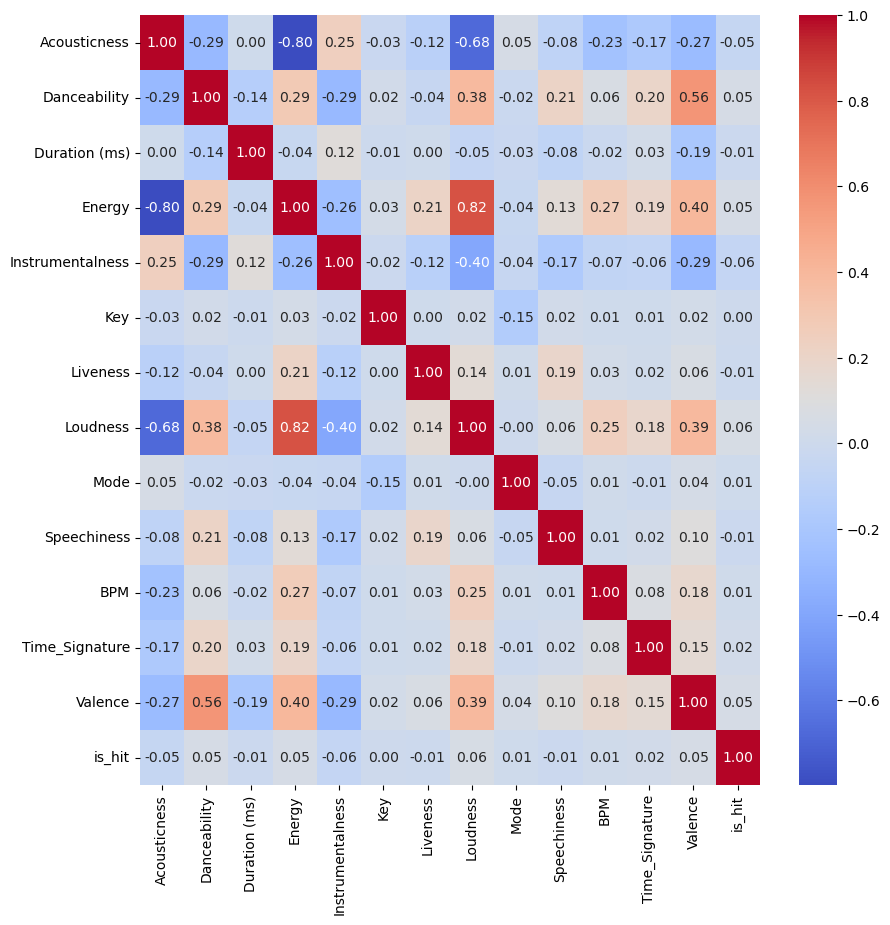

In [5]:
metrics = df.drop(['id', 'Title', 'Artist(s)'], axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(metrics.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

### Let's get an appropriate class balance for our models

In [6]:
df_non_hit = df[~df['is_hit']]
df_non_hit_sample = df_non_hit.sample(n=5*(len(df) - len(df_non_hit)), random_state=42)
df_non_hit_sample

,id,Title,Artist(s),Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BPM,Time_Signature,Valence,is_hit
965427,6x3o71W40LrdlVDIESphbu,Take These Dreams,Billie Williams,0.8830,0.7190,194960,0.2460,0.008170,7.0,0.1190,-10.152,1.0,0.0329,136.117,4.0,0.2520,False
909071,7tovX0UQyQNkyYWzM4p7OP,Dark Noontide,Six Organs Of Admittance,0.0546,0.1280,415173,0.5250,0.743000,5.0,0.3060,-10.409,1.0,0.0346,84.349,1.0,0.0334,False
176226,51OsHCAx9dOsxT2yFEyCBU,Wouldn't It Be Loverly,"['Julie Andrews', "" 'Reid Shelton"", "" 'Glenn K...",0.9280,0.4680,234840,0.2040,0.000010,5.0,0.0673,-13.332,1.0,0.0368,117.551,4.0,0.3640,False
95398,07r7tEyTVs6tNoFGu963rC,Low Life Mafia,"['Mr. Man', "" 'Mr. Celsta""]",0.0121,0.9160,298013,0.8170,0.000000,9.0,0.1450,-5.940,0.0,0.1760,141.947,4.0,0.7560,False
589232,7bLQzpcrrZvgGayC6PWZUw,Stille Nacht,Kristina Bach,0.8640,0.0927,168960,0.1910,0.000035,5.0,0.0930,-10.345,0.0,0.0336,172.152,5.0,0.0730,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12182,5ODMjVGhh3sCvZS473QnKb,"Ich halte es dafur, BuxWV 48: Du gibest mir Ruh","['Dietrich Buxtehude', "" 'Suzie LeBlanc"", "" 'P...",0.7190,0.3580,29160,0.0248,0.175000,3.0,0.1380,-25.407,1.0,0.0362,79.061,4.0,0.2930,False
963866,7pC0eoToyyMFX9ReUlVcH9,Just A Closer Walk With Thee,Hylo Brown & The Timberliners,0.5890,0.5950,121547,0.1130,0.000000,1.0,0.3810,-15.421,1.0,0.0454,96.540,4.0,0.2680,False
804472,4ARoX0nF6lq3x5u5t8ktkD,A Child for All Seasons,David Lanz,0.9940,0.5720,287120,0.0826,0.926000,5.0,0.1300,-22.011,1.0,0.0472,115.237,4.0,0.1020,False
544901,0u3SxY3hKH1Yggg1rJud3k,ANY MAN OF MINE,Shania Twain,0.2090,0.5600,244800,0.7270,0.000000,3.0,0.1210,-8.655,1.0,0.0469,156.380,4.0,0.8150,False


In [7]:
df_hit = df[df['is_hit']]
df_hit

,id,Title,Artist(s),Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BPM,Time_Signature,Valence,is_hit
285493,1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,The KLF,0.015800,0.617,216270,0.872,0.112000,8.0,0.4080,-12.305,1.0,0.0480,111.458,4.0,0.504,True
285494,6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),Pitbull,0.014200,0.825,237120,0.743,0.000021,2.0,0.2370,-5.995,1.0,0.1490,127.045,4.0,0.800,True
285495,70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,Britney Spears,0.560000,0.677,312533,0.665,0.000001,7.0,0.3380,-5.171,1.0,0.0305,74.981,4.0,0.706,True
285496,1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,The Kinks,0.568000,0.683,233400,0.728,0.000051,9.0,0.0384,-8.920,1.0,0.2590,75.311,4.0,0.833,True
285497,72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,The Rolling Stones,0.675000,0.319,448720,0.627,0.000073,0.0,0.2890,-9.611,1.0,0.0687,85.818,4.0,0.497,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000475,7ubq5fqmcPhfg1Q8s3HbbA,The Other Woman,Ray Parker Jr.,0.139000,0.909,247960,0.544,0.006140,9.0,0.4570,-11.692,1.0,0.0529,125.918,4.0,0.962,True
1010954,5zwwXMjE6OrqfVpYGnA9RW,Whistle (While You Work It),Katy Tiz,0.258000,0.697,215032,0.932,0.000000,2.0,0.2630,-3.157,1.0,0.1150,161.960,4.0,0.806,True
1117098,1yyvZbzPQzRx8OqEuUsRin,I'm The Leader Of The Gang (I Am),Gary Glitter,0.000123,0.249,208627,0.939,0.000004,2.0,0.2140,-9.152,1.0,0.2590,156.994,4.0,0.233,True
1130691,63ORXJXw7BvMJfabDND9di,Angel of the Morning,Merrilee Rush,0.526000,0.512,188207,0.165,0.000000,8.0,0.1610,-12.401,1.0,0.0261,81.059,4.0,0.332,True


In [8]:
data4model = pd.concat([df_non_hit_sample, df_hit], ignore_index=True)
data4model.drop(['id', 'Title', 'Artist(s)'], axis=1, inplace=True)
data4model

,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BPM,Time_Signature,Valence,is_hit
0,0.883000,0.7190,194960,0.246,0.008170,7.0,0.1190,-10.152,1.0,0.0329,136.117,4.0,0.2520,False
1,0.054600,0.1280,415173,0.525,0.743000,5.0,0.3060,-10.409,1.0,0.0346,84.349,1.0,0.0334,False
2,0.928000,0.4680,234840,0.204,0.000010,5.0,0.0673,-13.332,1.0,0.0368,117.551,4.0,0.3640,False
3,0.012100,0.9160,298013,0.817,0.000000,9.0,0.1450,-5.940,0.0,0.1760,141.947,4.0,0.7560,False
4,0.864000,0.0927,168960,0.191,0.000035,5.0,0.0930,-10.345,0.0,0.0336,172.152,5.0,0.0730,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50149,0.139000,0.9090,247960,0.544,0.006140,9.0,0.4570,-11.692,1.0,0.0529,125.918,4.0,0.9620,True
50150,0.258000,0.6970,215032,0.932,0.000000,2.0,0.2630,-3.157,1.0,0.1150,161.960,4.0,0.8060,True
50151,0.000123,0.2490,208627,0.939,0.000004,2.0,0.2140,-9.152,1.0,0.2590,156.994,4.0,0.2330,True
50152,0.526000,0.5120,188207,0.165,0.000000,8.0,0.1610,-12.401,1.0,0.0261,81.059,4.0,0.3320,True


### Now our data has 1 : 5 ratio  of hits to normal tracks 
### Double checking the correlations for this data

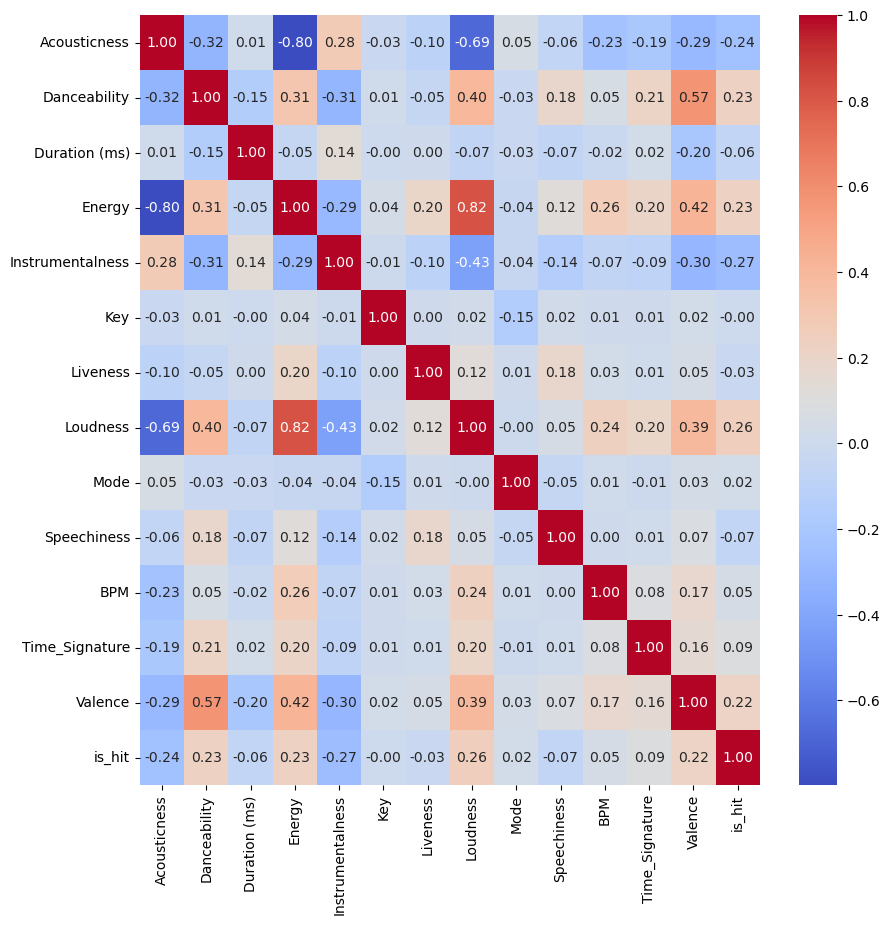

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(data4model.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

### Basic pipeline for random forest and train test split

In [10]:
pipe_base = Pipeline([('scale', StandardScaler()), ('rfr', RandomForestClassifier(max_depth=7))])
X_train, X_test, y_train, y_test = train_test_split(data4model.drop(['is_hit'], axis=1) , data4model['is_hit'], test_size=.3, random_state = 31)

### Cross Validation function and running on our base pipeline

### Our main metric for our models will be precision

In [11]:
def cross_validation_pip(X_train, y_train, estimator, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list, score_val_list = [], []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        estimator.fit(X_train_fold, y_train_fold)
        
        # now how did we do?
        score_val_list.append(precision_score(y_val_fold, estimator.predict(X_val_fold)))
        score_train_list.append(precision_score(y_train_fold, estimator.predict(X_train_fold)))
    
    return {'train_precision': np.mean(score_train_list), 'validation_precision': np.mean(score_val_list)}
cross_validation_pip(X_train, y_train, pipe_base)

{'train_precision': 0.7953408017901932,
 'validation_precision': 0.7780864861066292}

### Confusion Matrix Display for base pipeline

              precision    recall  f1-score   support

       False       0.84      1.00      0.91     12511
        True       0.80      0.03      0.06      2536

    accuracy                           0.84     15047
   macro avg       0.82      0.52      0.49     15047
weighted avg       0.83      0.84      0.77     15047



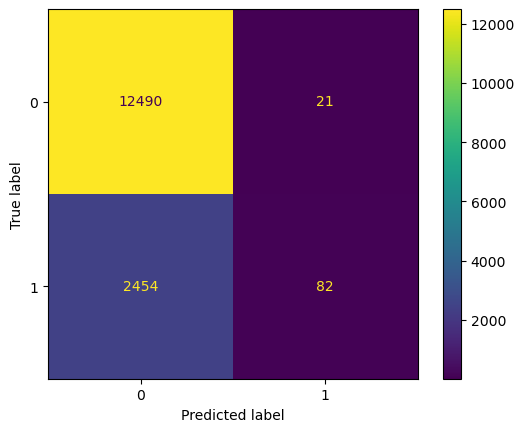

In [12]:
y_pred = pipe_base.predict(X_test)
cfmat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cfmat).plot()
print(classification_report(y_test, y_pred))

### Optimizing the base pipeline

In [13]:
pipe_grid = {'rfr__max_depth': [4,5,6,7],
             'rfr__n_estimators': [x for x in range(100,251,50)]}
gs_pipe = GridSearchCV(estimator=pipe_base, param_grid=pipe_grid, scoring = 'precision')

In [14]:
gs_pipe.fit(X_train, y_train);

In [15]:
pipe_opt = Pipeline([('scale', StandardScaler()), ('rfr', RandomForestClassifier(max_depth=gs_pipe.best_params_['rfr__max_depth'], n_estimators=gs_pipe.best_params_['rfr__n_estimators']))])
X_train, X_test, y_train, y_test = train_test_split(data4model.drop(['is_hit'], axis=1) , data4model['is_hit'], test_size=.3, random_state = 31)

### Cross Validation for the optimized pipeline

In [16]:
cross_validation_pip(X_train, y_train, pipe_opt)

{'train_precision': 0.7950726006331168,
 'validation_precision': 0.7647082055244266}

### Confusion Matrix Display for optimized pipeline

              precision    recall  f1-score   support

       False       0.84      1.00      0.91     12511
        True       0.80      0.03      0.06      2536

    accuracy                           0.84     15047
   macro avg       0.82      0.52      0.49     15047
weighted avg       0.83      0.84      0.77     15047



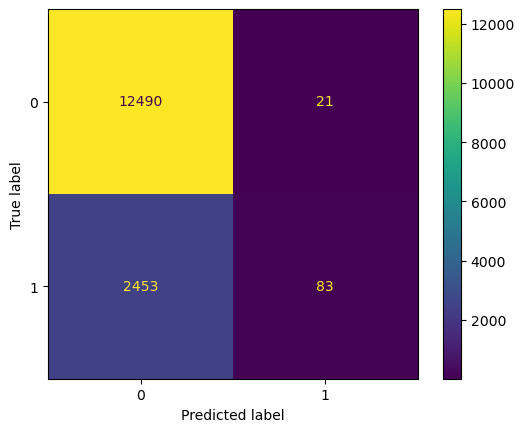

In [17]:
y_pred = pipe_opt.predict(X_test)
cfmat2 = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cfmat2).plot()
print(classification_report(y_test, y_pred))

### Let's see what makes the random forest model tick

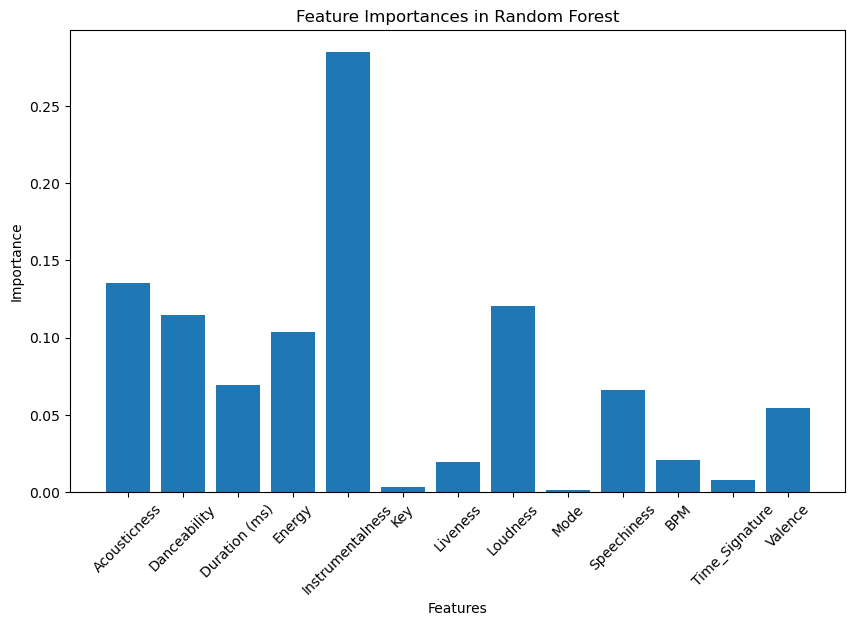

In [18]:
imp_ref = {X_train.columns[i]: pipe_opt.steps[1][1].feature_importances_[i] for i in range(len(X_train.columns))}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.xticks(rotation=45)
plt.show()

### Now let's try an Isolation Forest pipeline on all the data

In [19]:
pipe_isf = Pipeline([('scale', StandardScaler()), ('isf', IsolationForest(n_estimators=300))])
X_train100, X_test100, y_train100, y_test100 = train_test_split(metrics.drop(['is_hit'], axis=1) , metrics['is_hit'], test_size=.3, random_state = 31)

In [20]:
pipe_isf.fit(X_train100)

Pipeline(steps=[('scale', StandardScaler()),
                ('isf', IsolationForest(n_estimators=300))])

In [21]:
X_train100['isf'] = pipe_isf.predict(X_train100)

### Getting precision

In [22]:
abnorm_ind = list(X_train100[X_train100['isf'] == 1].index)

In [23]:
len([x for x in y_train100[abnorm_ind] if x]) / len(y_train100[abnorm_ind]) 

0.008846077021103306

### Turns out this  model is a dud

### Next we will try a CatBoost model

In [24]:
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=False, l2_leaf_reg=3)
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

### Seeing if there is a good place to do an early stop on validation

In [25]:
cbc.fit(train_pool)
met = cbc.eval_metrics(train_pool, metrics=['Precision'], plot=True)
 
# Print the precision metric
precision = met['Precision'][-1]
 
print(f'Precision: {precision:.2f}')

Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.94


### CatBoost's cross vaildation function

In [26]:
def cross_validation_cbc(X_train, y_train, estimator, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list, score_val_list = [], []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        estimator.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))
        
        # now how did we do?
        score_val_list.append(precision_score(y_val_fold, estimator.predict(X_val_fold)))
        score_train_list.append(precision_score(y_train_fold, estimator.predict(X_train_fold)))
    
    return {'train_precision': np.mean(score_train_list), 'validation_precision': np.mean(score_val_list)}
cross_validation_cbc(X_train, y_train, cbc)

{'train_precision': 0.7998182481081282,
 'validation_precision': 0.6229069486380782}

### Confusion Matrix Display for CatBoost

              precision    recall  f1-score   support

       False       0.87      0.97      0.91     12511
        True       0.62      0.28      0.39      2536

    accuracy                           0.85     15047
   macro avg       0.75      0.62      0.65     15047
weighted avg       0.83      0.85      0.83     15047



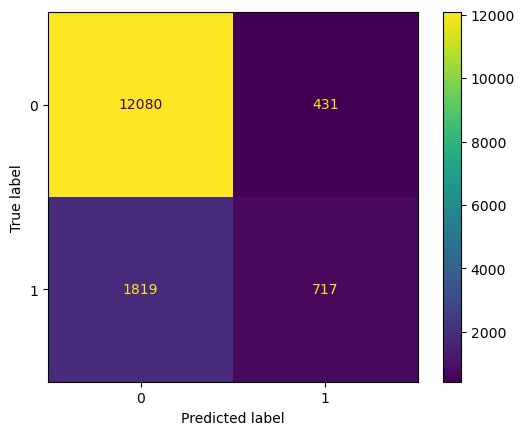

In [27]:
y_pred = cbc.predict(X_test)
cfmat3 = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cfmat3).plot()
print(classification_report(y_test, y_pred))

### Let's see what makes the CatBoost model tick

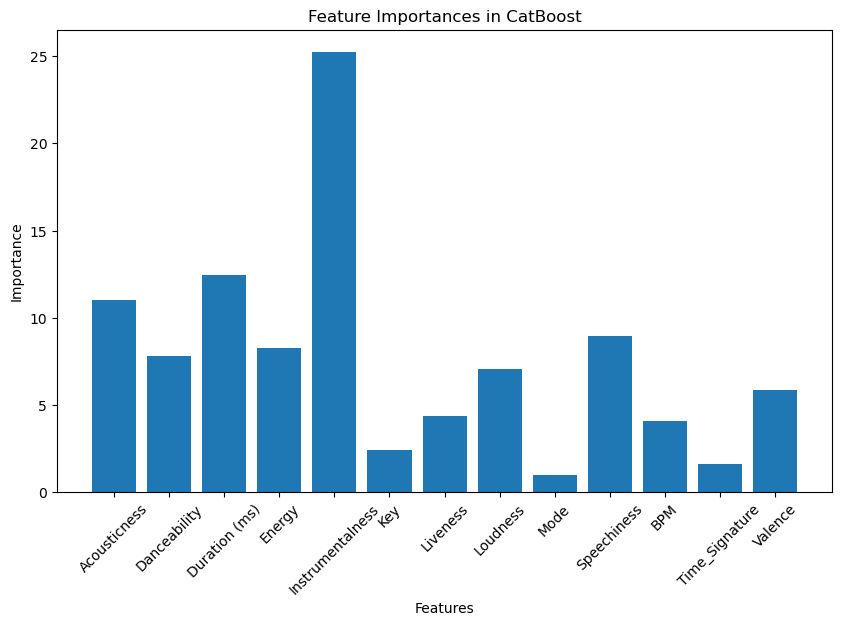

In [28]:
imp_ref = {X_train.columns[i]: cbc.get_feature_importance()[i] for i in range(len(X_train.columns))}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in CatBoost')
plt.xticks(rotation=45)
plt.show()

### Let's try training and testing on SMOTE data (although less realistic)

In [29]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(metrics.drop(['is_hit'], axis=1) , metrics['is_hit'])
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(metrics.drop(['is_hit'], axis=1) , metrics['is_hit'], test_size=.3, random_state = 31)
X_train_res_sample = X_train_res.sample(n=10**5)
y_train_res_sample = y_train_res[X_train_res_sample.index]
cbc2 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=False, l2_leaf_reg=3)
cbc2.fit(X_train_res_sample, y_train_res_sample)

### Confusion Matrix Display for CatBoosted SMOTE

              precision    recall  f1-score   support

       False       0.84      1.00      0.91     12511
        True       1.00      0.03      0.06      2536

    accuracy                           0.84     15047
   macro avg       0.92      0.52      0.48     15047
weighted avg       0.86      0.84      0.77     15047



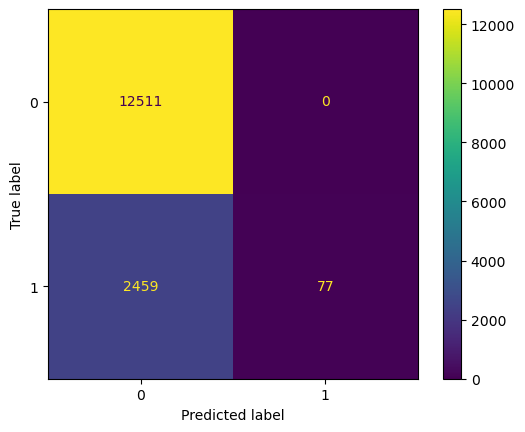

In [30]:
y_pred = cbc2.predict(X_test)
cfmat35 = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cfmat35).plot()
print(classification_report(y_test, y_pred))

### Preforms simiarly to the random forest model

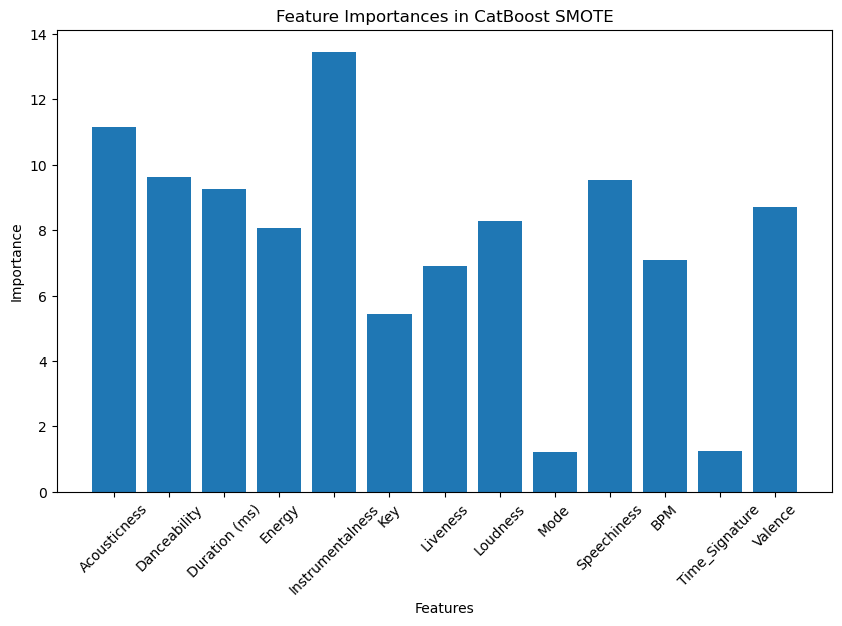

In [31]:
imp_ref = {X_train.columns[i]: cbc2.get_feature_importance()[i] for i in range(len(X_train.columns))}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in CatBoost SMOTE')
plt.xticks(rotation=45)
plt.show()

### But all features are treated mostly equal

### Now let's try an Extra Trees Classifier pipeline on 1 : 5 ratio data 

In [32]:
pipe_clf = Pipeline([('scale', StandardScaler()), ('clf', ExtraTreesClassifier(max_depth=7, n_estimators=150))])
pipe_clf.fit(X_train, y_train)
precision_score(y_train, pipe_clf.predict(X_train))

0.0

### Turns out this  model is a dud

### Next we will try a Logistic Regression model

In [33]:
pipe_log = Pipeline([('scale', StandardScaler()), ('log', LogisticRegression())])
cross_validation_pip(X_train, y_train, pipe_log)

{'train_precision': 0.5753633423903224,
 'validation_precision': 0.5775516764217863}

### And optimized 

In [34]:
pipe_grid = {'log__C': [10**x for x in range(-4,5)]}
gs_pipe = GridSearchCV(estimator=pipe_log, param_grid=pipe_grid, scoring = 'precision')
gs_pipe.fit(X_train, y_train)
gs_pipe.best_params_

{'log__C': 0.01}

In [35]:
pipe_log_opt = Pipeline([('scale', StandardScaler()), ('log', LogisticRegression(C=10**-2))])
cross_validation_pip(X_train, y_train, pipe_log_opt)

{'train_precision': 0.587430629499166,
 'validation_precision': 0.5935477911176725}

### Not as good as Catboost

### Confusion Matrix Display for  Logistic Regression

              precision    recall  f1-score   support

       False       0.84      0.99      0.91     12511
        True       0.59      0.08      0.14      2536

    accuracy                           0.84     15047
   macro avg       0.71      0.53      0.52     15047
weighted avg       0.80      0.84      0.78     15047



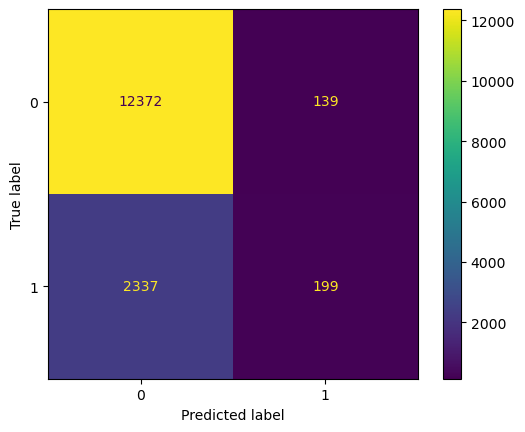

In [36]:
y_pred = pipe_log_opt.predict(X_test)
cfmat4 = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cfmat4).plot()
print(classification_report(y_test, y_pred))

### Logistic Regression should give us a deeper understanding of the feature importances in this problem

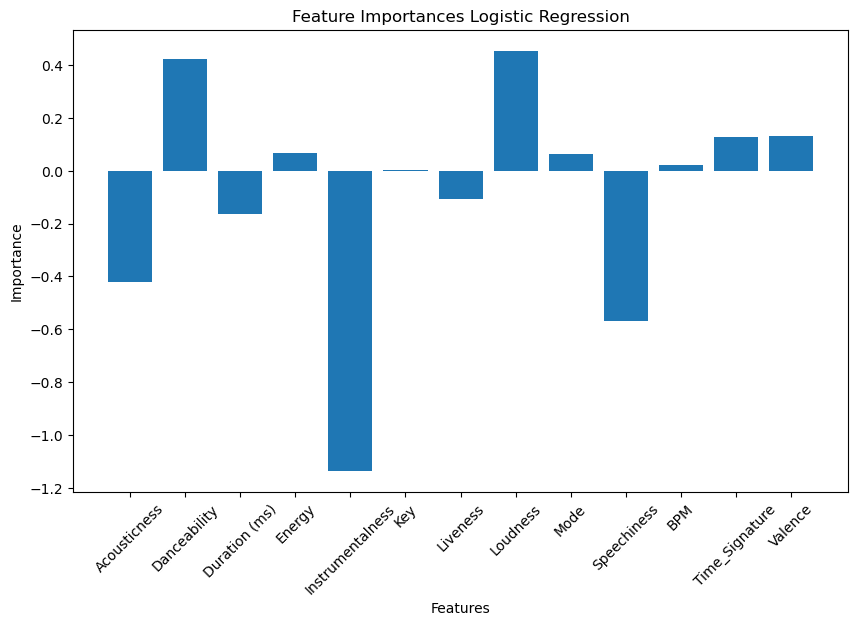

In [37]:
imp_ref = {X_train.columns[i]: pipe_log_opt.steps[1][1].coef_[0][i] for i in range(len(X_train.columns))}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances Logistic Regression')
plt.xticks(rotation=45)
plt.show()

### Lastly we will try an SVM Pipleline model

In [38]:
pipe_svc = Pipeline([('scale', StandardScaler()), ('svc', SVC(gamma='auto', kernel='rbf'))])
cross_validation_pip(X_train, y_train, pipe_svc)

{'train_precision': 0.7604412648324697,
 'validation_precision': 0.7367836257309942}

### Confusion Matrix Display for SVM

              precision    recall  f1-score   support

       False       0.83      1.00      0.91     12511
        True       0.78      0.01      0.01      2536

    accuracy                           0.83     15047
   macro avg       0.81      0.50      0.46     15047
weighted avg       0.82      0.83      0.76     15047



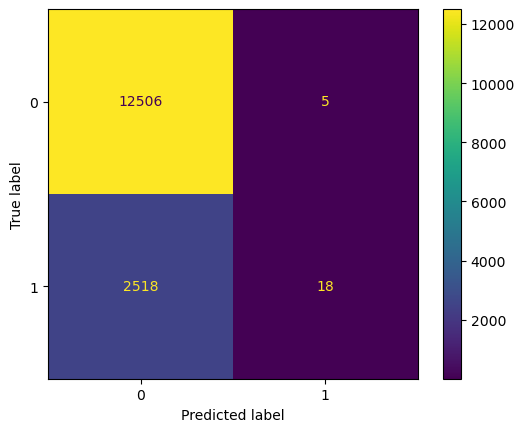

In [39]:
y_pred = pipe_svc.predict(X_test)
cfmat5 = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cfmat5).plot()
print(classification_report(y_test, y_pred))

### Perfroms similarly to Random Forest

### Now we will test the Cat Boost model and the Logistic Regression model with covers of popular songs and tracks from theatrical musicals to test how well they filter
### We won't use random forest or SVM because they are suited for a playlists with thousands of tracks and these playlists are about a few hundred to a little over a thousand

### First the covers

In [40]:
df_covers = pd.read_csv('Covered\Clean_Covers.csv').drop('Unnamed: 0', axis=1)

### Predicting and saving the results

In [41]:
metrics_covers = df_covers.drop(['id', 'Title', 'Artist(s)'], axis=1)
df_covers['may_hit_cbc'] = cbc.predict(metrics_covers)
df_covers['may_hit_log'] = pipe_log_opt.predict(metrics_covers)

### Here they are

In [42]:
df_covers[df_covers['may_hit_cbc']]

,id,Artist(s),Title,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BMP,Time_Signature,Valence,may_hit_cbc,may_hit_log
8,3wQxUfquHLpgHoU6fo8Z50,Weezer,No Scrubs,0.188000,0.690,190280,0.798,0.000000,8,0.1110,-3.347,0,0.0390,92.967,4,0.645,True,False
48,1YxE1cKYJztCvSfpPYS85G,Skindred,Electric Avenue,0.005900,0.654,190853,0.947,0.000000,2,0.0851,-4.788,1,0.0761,129.862,4,0.931,True,True
60,2CSbx5XAFortinS8hJ3IiC,Natalie Jane,Crazy,0.264000,0.556,168421,0.711,0.000000,8,0.1020,-4.599,1,0.0414,113.801,4,0.267,True,False
65,6DGujQojYKebtgnq9SGT0B,"Bright Light Bright Light,808 BEACH",Too Funky,0.002840,0.566,225900,0.714,0.000000,2,0.0874,-6.506,1,0.1200,200.136,4,0.671,True,False
69,11A8jtMu8WKkLeq6CpZNsl,Arkells,Dancing On My Own,0.000343,0.545,230293,0.879,0.000160,2,0.3750,-3.727,1,0.0483,134.910,4,0.484,True,False
71,5YM7Ae4VUe7LNtvCcYpUcA,Kylie Cantrall,Boo'd Up,0.165000,0.538,227545,0.679,0.000000,3,0.0755,-7.841,1,0.0637,165.146,4,0.367,True,False
73,0z0kUUd2jPQiI2Ob8VXajc,"Niall Horan,Anne-Marie",Everywhere (BBC Children In Need),0.049200,0.638,171413,0.910,0.005110,6,0.1370,-2.100,0,0.0402,115.016,4,0.539,True,False
89,0cgFnx6yIVv3RrqXlZTiGZ,Smith & Thell,I Wanna Dance With Somebody - Who Loves Me,0.038000,0.593,203538,0.787,0.000000,2,0.1940,-6.429,1,0.0327,125.957,4,0.507,True,False
123,5My4LtZW8JQJoKFDWodqIt,Shawn Mendes,Use Somebody - Recorded at Spotify Studios NYC,0.350000,0.366,176586,0.519,0.000000,5,0.1450,-6.066,1,0.0331,124.632,4,0.308,True,False
126,2GSzaHXWxiHCo0pk0uOOpE,Madison Rose,True Colors (Spotify Singles),0.024100,0.580,200655,0.683,0.000000,0,0.2070,-4.996,1,0.0436,121.997,4,0.490,True,False


In [43]:
df_covers[df_covers['may_hit_log']]

,id,Artist(s),Title,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BMP,Time_Signature,Valence,may_hit_cbc,may_hit_log
25,6opIwpImZYdxNgG4wpDxED,"John Mellencamp,Meshell Ndegeocello",Wild Night,0.06950,0.665,207506,0.888,0.001470,7,0.1040,-4.433,1,0.0552,144.339,4,0.951,False,True
30,2tpPgG8Xkdbhn5xf77EVPP,Creedence Clearwater Revival,I Heard It Through The Grapevine - Edit,0.10500,0.917,233066,0.627,0.004000,2,0.0588,-8.045,1,0.0407,117.577,4,0.745,False,True
44,6Um3XCAxl9YfFmAnGl93xc,The Bobby Fuller Four,I Fought the Law - Single Version,0.10500,0.593,138360,0.804,0.000002,7,0.0470,-5.497,1,0.0319,148.959,4,0.962,False,True
48,1YxE1cKYJztCvSfpPYS85G,Skindred,Electric Avenue,0.00590,0.654,190853,0.947,0.000000,2,0.0851,-4.788,1,0.0761,129.862,4,0.931,True,True
56,7hLkwgguzGRq1rTyA3P9pr,Bakar,A Girl Like You,0.06090,0.866,116852,0.784,0.050800,5,0.1270,-6.321,0,0.0411,130.056,4,0.897,False,True
304,2NCLpp3XqZXNteWgyyk9AO,"Freedom Dub,Luca Giacco",I'm Not in Love,0.08410,0.744,235000,0.681,0.003460,9,0.0794,-6.322,1,0.0325,143.963,4,0.782,False,True
352,0lEsQGoR01bHWNWH9VO2Fw,Luca Giacco,Save Your Tears,0.03280,0.801,172000,0.574,0.000003,7,0.1780,-9.091,1,0.0353,127.996,4,0.728,False,True
364,4rgA4ZZsWJQggzwxnuksIz,Natty Bong,No Rain,0.02670,0.828,235046,0.560,0.001950,9,0.0466,-5.758,1,0.0307,120.048,4,0.624,False,True
370,37ELOJ1m3ql1ssiiJvGqic,"Urban Love,Nikko Mad",Run,0.11700,0.894,151475,0.592,0.017900,9,0.0893,-5.701,0,0.0611,121.986,4,0.728,False,True
379,5hqzT8JtqdXFnk2EiGv5P0,"Olivia Wayne,Javier Penna",About Damn Time,0.00472,0.846,152295,0.637,0.000035,3,0.0686,-7.694,0,0.0474,114.992,4,0.517,False,True


### Any overlap?

In [44]:
df_covers[(df_covers['may_hit_log']) & (df_covers['may_hit_cbc'])]

,id,Artist(s),Title,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BMP,Time_Signature,Valence,may_hit_cbc,may_hit_log
48,1YxE1cKYJztCvSfpPYS85G,Skindred,Electric Avenue,0.0059,0.654,190853,0.947,0.000000,2,0.0851,-4.788,1,0.0761,129.862,4,0.931,True,True
396,1x7NAvqHgCvhV549ls0FTE,"Thierry Von Der Warth,Horizon Blue,Carston",Sunset Lovers,0.0234,0.806,176000,0.741,0.000037,1,0.0746,-6.362,0,0.0471,119.971,4,0.563,True,True


### Same for musicals 

In [45]:
df_muse = pd.read_csv('Covered\Clean_Muse.csv').drop('Unnamed: 0', axis=1)

In [46]:
metrics_covers = df_muse.drop(['id', 'Title', 'Artist(s)'], axis=1)
df_muse['may_hit_cbc'] = cbc.predict(metrics_covers)
df_muse['may_hit_log'] = pipe_log_opt.predict(metrics_covers)

In [47]:
df_muse[df_muse['may_hit_cbc']]

,id,Artist(s),Title,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BMP,Time_Signature,Valence,may_hit_cbc,may_hit_log
10,7FIrk5lA1IalpZ3OtieeC8,"Rachel Bay Jones,Kristolyn Lloyd,Will Roland,B...",Good For You,0.17500,0.627,185146,0.709,0.000000,3,0.2420,-4.692,1,0.0726,107.802,4,0.791,True,False
160,26RykSLUNpC2BymCxJgvTn,"Anthony Rapp,Adam Pascal,Jesse L. Martin,Taye ...",Rent,0.00476,0.447,239306,0.958,0.000000,7,0.1140,-2.724,1,0.1360,182.142,4,0.522,True,False
164,5iMg31WQw8WdCHrvYWhloq,"Jesse L. Martin,Wilson Jermaine Heredia,Anthon...",Today 4 U,0.04300,0.724,164920,0.940,0.000043,7,0.1420,-3.155,1,0.0507,132.006,4,0.684,True,True
165,2lH6RlA7NA2CcTfyEsONTc,"Tracie Thoms,Anthony Rapp",Tango: Maureen,0.31400,0.799,235040,0.621,0.000000,7,0.1530,-4.992,1,0.0599,128.002,4,0.747,True,False
182,5fiRubxolDeCN6x2LTD7Dq,"Adam Pascal,Anthony Rapp",What You Own,0.02810,0.539,238053,0.854,0.000000,2,0.3180,-3.360,1,0.0341,133.932,4,0.526,True,False
346,53sz4K5pKUWMINwSgD5peH,"Erika Henningsen,Original Broadway Cast of Mea...",It Roars,0.11900,0.537,211120,0.753,0.000000,10,0.1610,-4.952,1,0.0609,107.352,4,0.579,True,False
350,03uQyt8Bdnt2paQgCWZl5v,"Barrett Wilbert Weed,Erika Henningsen",Apex Predator,0.09100,0.656,194280,0.804,0.000000,0,0.2970,-4.350,1,0.0894,111.960,4,0.489,True,False
364,42kiFUenq5MVKpmCwjh1Cu,"Erika Henningsen,Kerry Butler,Cheech Manohar,M...",Do This Thing,0.10000,0.555,213560,0.740,0.000000,8,0.1670,-4.523,1,0.1290,102.479,4,0.618,True,False
365,21bID4wyC6UVdtmVMxRbUW,"Erika Henningsen,Original Broadway Cast of Mea...",I See Stars,0.13300,0.355,228973,0.755,0.000000,9,0.1150,-4.165,1,0.0702,146.143,4,0.238,True,False
373,28d3XyYdrWWPQ9HNAPuteZ,"Patti Murin,John Riddle",Love Is an Open Door - From Frozen: The Broadw...,0.13200,0.564,190440,0.562,0.000000,6,0.0938,-6.590,0,0.0664,103.767,4,0.505,True,False


In [48]:
df_muse[df_muse['may_hit_log']]

,id,Artist(s),Title,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BMP,Time_Signature,Valence,may_hit_cbc,may_hit_log
164,5iMg31WQw8WdCHrvYWhloq,"Jesse L. Martin,Wilson Jermaine Heredia,Anthon...",Today 4 U,0.04300,0.724,164920,0.940,0.000043,7,0.1420,-3.155,1,0.0507,132.006,4,0.684,True,True
528,5Q41ne9bvWMh5NZXgmMIyc,"Christopher Fitzgerald,Kimiko Glenn,Waitress O...",I Love You Like a Table,0.19800,0.739,116013,0.642,0.000000,8,0.1180,-5.460,1,0.0403,126.053,4,0.809,False,True
771,0Wf6n5vnawBcIsqehqUkeT,"Aaron Tveit,Karen Olivo,Sahr Ngaujah,Ricky Roj...",Shut Up And Raise Your Glass,0.00769,0.693,162093,0.799,0.000002,0,0.1400,-4.971,1,0.0373,128.032,4,0.595,True,True
973,4OF43pYQRzgJwHiPrfgaMN,"Caitlin Kinnunen,The Prom Ensemble",You Happened,0.21800,0.786,196226,0.710,0.000000,0,0.0382,-5.378,1,0.0477,130.002,4,0.868,True,True


In [49]:
df_muse[(df_muse['may_hit_log']) & (df_muse['may_hit_cbc'])]

,id,Artist(s),Title,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,BMP,Time_Signature,Valence,may_hit_cbc,may_hit_log
164,5iMg31WQw8WdCHrvYWhloq,"Jesse L. Martin,Wilson Jermaine Heredia,Anthon...",Today 4 U,0.04300,0.724,164920,0.940,0.000043,7,0.1420,-3.155,1,0.0507,132.006,4,0.684,True,True
771,0Wf6n5vnawBcIsqehqUkeT,"Aaron Tveit,Karen Olivo,Sahr Ngaujah,Ricky Roj...",Shut Up And Raise Your Glass,0.00769,0.693,162093,0.799,0.000002,0,0.1400,-4.971,1,0.0373,128.032,4,0.595,True,True
973,4OF43pYQRzgJwHiPrfgaMN,"Caitlin Kinnunen,The Prom Ensemble",You Happened,0.21800,0.786,196226,0.710,0.000000,0,0.0382,-5.378,1,0.0477,130.002,4,0.868,True,True


## Summary 

### Uses for the models 
   - Random Forest and SVM for fillter for thousands of tracks, useful for big tv shows like American Idol and The Voice that get a lot of entries and are only looking for a select few.
   - CatBoost and Logistic Regression are more suited to filter through a spotify playlist 
   
### What makes hit
   - Less instruments and more vocals, but not too much.
   - A track that is loud and you can dance to is important for a track to be a hit

### Bonus: Graphs used in slides

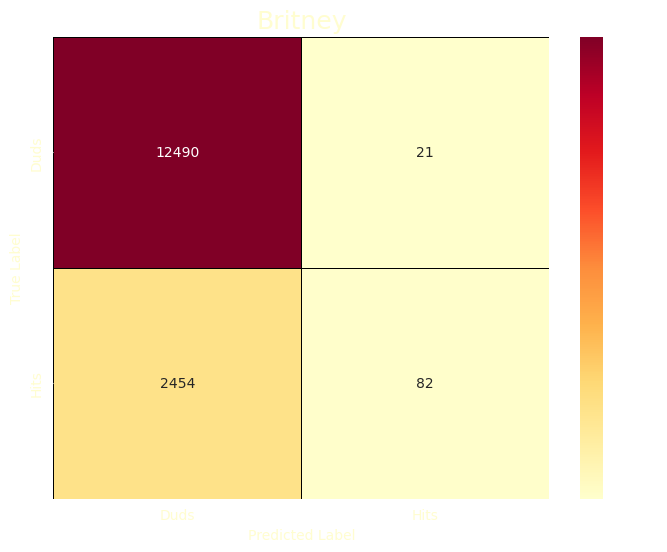

In [50]:
plt.figure(figsize=(8, 6))
plt.style.use('dark_background')

# Create a color map ranging from orange to yellow
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Plot the confusion matrix
sns.heatmap(cfmat, annot=True, fmt="d", cmap=cmap, cbar=True, linewidths=.5, xticklabels=['Duds', 'Hits'], yticklabels=['Duds', 'Hits'], linecolor='black')
plt.xlabel('Predicted Label', color='#FFFDD0')
plt.ylabel('True Label', color='#FFFDD0')
plt.title('Britney', color='#FFFDD0', fontsize=18)


# Set the tick colors to white
plt.xticks(color='#FFFDD0')
plt.yticks(color='#FFFDD0')

# Display the plot
plt.show()

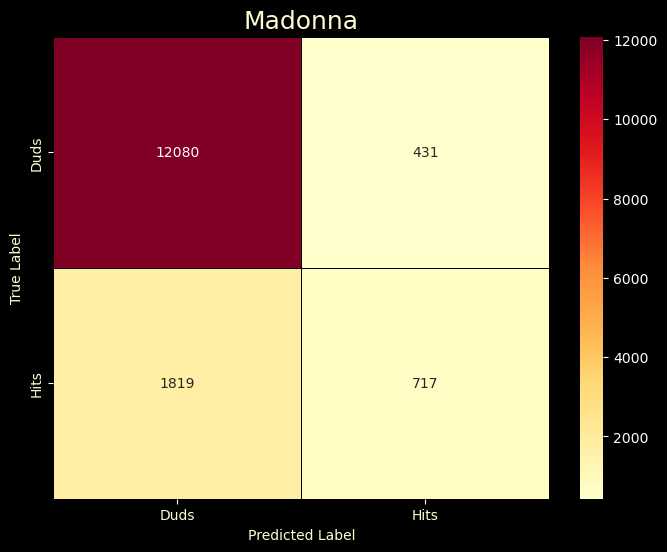

In [51]:
plt.figure(figsize=(8, 6))
plt.style.use('dark_background')

# Create a color map ranging from orange to yellow
cmap = sns.color_palette("YlOrRd", as_cmap=True)

# Plot the confusion matrix
sns.heatmap(cfmat3, annot=True, fmt="d", cmap=cmap, cbar=True, linewidths=.5, xticklabels=['Duds', 'Hits'], yticklabels=['Duds', 'Hits'], linecolor='black')
plt.xlabel('Predicted Label', color='#FFFDD0')
plt.ylabel('True Label', color='#FFFDD0')
plt.title('Madonna', color='#FFFDD0', fontsize=18)


# Set the tick colors to white
plt.xticks(color='#FFFDD0')
plt.yticks(color='#FFFDD0')

# Display the plot
plt.show()

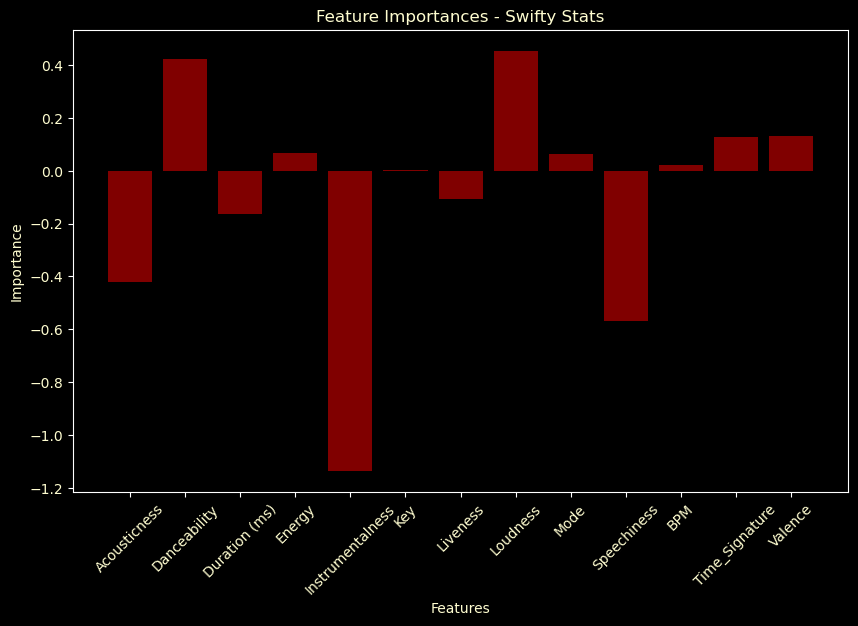

In [52]:
imp_ref = {X_train.columns[i]: pipe_log_opt.steps[1][1].coef_[0][i] for i in range(len(X_train.columns))}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values(), color='#800000')
plt.xlabel('Features', color='#FFFDD0')
plt.ylabel('Importance', color='#FFFDD0')
plt.title('Feature Importances - Swifty Stats', color='#FFFDD0')
plt.xticks(rotation=45)

# Set the tick colors to white
plt.xticks(color='#FFFDD0')
plt.yticks(color='#FFFDD0')
plt.show()